In [1]:
import tools

In [2]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [3]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()
print(os.getenv("LANGSMITH_ENDPOINT"))

https://api.smith.langchain.com


In [4]:
%pip install -U langchain langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os

import os
from langchain.chat_models import init_chat_model



llm = init_chat_model(
    "azure_openai:gpt-4.1-nano",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    api_version="2024-12-01-preview"
)

agent_tools = [tools.get_all_plants, tools.get_bloom_data]
llm_with_tools = llm.bind_tools(agent_tools)

In [6]:
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
import functools
from utils import make_specialist

        

In [8]:
plant = "erle"
blooming = functools.partial(tools.get_bloom_data, plant=plant)

@rename(f"get_bloom_data_{plant}")

def get_bloom_data(year: int):
    """
    Get bloom data for the specified plant and year.

    Args:
        year (int): The year for which to retrieve bloom data.

    Returns:
        dict: A dictionary containing bloom data and additional information.
    """
    return blooming(year = year)

get_bloom_data(2023)

{'data': {'Jahr': {2: 2023},
  'Gebietsmittel': {2: '20.02. '},
  'Abweichung vom Mittel': {2: '-8 Tage'}},
 'info': 'Tabelle mit den mittleren Beobachtungsterminen und den Abweichungen vom Mittel der Phase "Erle: Blüh-Beginn" im Gebiet Deutschland für verschiedene Jahre. Positive Abweichungen bedeuten, dass die Phase im entsprechendem Jahr später aufgetreten ist.'}

In [9]:
import os
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search.invoke("Was ist die Blütezeit von Sonnenblumen?")

{'error': ValueError("Error 432: This request exceeds your plan's set usage limit. Please upgrade your plan or contact support@tavily.com")}

In [10]:
fallback_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    prompt=(
        'Aufgaben:'
        '- Du bist ein Assistent, der Informationen über die Blütezeit von Pflanzen bereitstellt. Suche im Internet nach Informationen.'
        'Antworte in JSON und folge dem Schema: {"type": "object","properties": {"response": {"type": "string","enum": ["yes", "no", "no answer"]},reasoning": {"type": "string"}},"required": ["response", "reasoning"]}'
        'response soll auf "yes" gesetzt werden, wenn die Pflanze blüht und "no", wenn sie nicht blüht. Falls du dir nicht sicher bist antworte mit "no answer".'
    ),
    name="fallback_agent",
)

In [11]:
plants = tools.get_all_plants().split(" ")
print(plants)
#create specialists
specialists = {plant: make_specialist(plant, llm) for plant in plants}
[specialist.name for specialist in specialists.values()]

['apfel', 'birke', 'erle', 'hasel', 'winterraps', 'winterroggen', 'esche', 'forsythie', 'huflattich', 'loewenzahn', 'schneegloeckhen', 'beifuss']


['apfel_agent',
 'birke_agent',
 'erle_agent',
 'hasel_agent',
 'winterraps_agent',
 'winterroggen_agent',
 'esche_agent',
 'forsythie_agent',
 'huflattich_agent',
 'loewenzahn_agent',
 'schneegloeckhen_agent',
 'beifuss_agent']

In [12]:
from langgraph_supervisor import create_supervisor
from langgraph_supervisor.handoff import create_forward_message_tool


forwarding_tool = create_forward_message_tool("supervisor") # The argument is the name to assign to the resulting forwarded message



supervisor = create_supervisor(
    model =llm,
    agents= list(specialists.values()),
    prompt=(
        'Du bist ein Supervisor, der die Anfragen an Spezialisten weiterleitet. '
        'Anweisungen:'
        '- Wenn du eine Anfrage erhältst, leite sie an den passenden Spezialisten weiter. '
        '- Spezialisten sind benannt <plant>_agent, wobei <plant> der Name der Pflanze ist, für die Informationen benötigt werden.'
        '- Wenn kein passender Spezialist gefunden wird, antwort mit "no answer" und nutze folgendes format: {"type": "object","properties": {"response": {"type": "string","enum": ["yes", "no", "no answer"]},reasoning": {"type": "string"}},"required": ["response", "reasoning"]}'
        'Wichtig!:'
        '- Antworte auf keinen fall selbst!'
        '- Nutze statt zu antworten forwarding_tool, um die Antworten der spezialisten und des fallback_agents an __end__ weiterzuleiten.'
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
    tools=[forwarding_tool],
).compile()

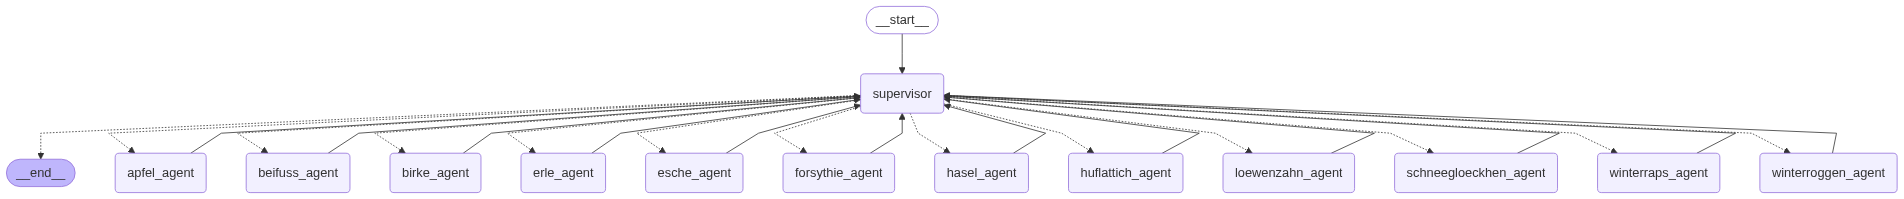

In [13]:


from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))



In [14]:
# hide-cell
from langchain_core.messages import convert_to_messages
from utils import pretty_print_message, pretty_print_messages

In [ ]:
import json
from utils import get_tokens
#base_prompt = 'Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }'
with open("datasets/dataset_850.json", "r") as file:
    dataset = json.load(file)


responses = []
count = 0
for data in dataset:
    sentence = data["sentence"]
    prompt = [HumanMessage(content=sentence)]
    print(f"Processing: {sentence}")
    try:
        messages = supervisor.invoke({"messages": prompt})
    except Exception as e:
        responses.append({
            "id": data["id"],
            "plant": data["plant"],
            "city": data["city"],
            "date": data["date"],
            "sentence": sentence,
            "response": "error",
            "reasoning": str(e),
            "tokens": 0
        })
        print(f"Error processing {sentence}: {e}")
        continue
    
    for m in messages['messages']:
        m.pretty_print()
    response = messages["messages"][-1].content
    cleaned_response = response.strip("```json").strip("```").strip()
    try:
        response_json = json.loads(cleaned_response)
    except json.JSONDecodeError as e:
        #sometimes the agent decides not to use the tool but to answer directly
        response = messages["messages"][-4].content
        cleaned_response = response.strip("```json").strip("```").strip()
        response_json = json.loads(cleaned_response)
    tokens = get_tokens(messages)
    responses.append({
        "id": data["id"],
        "plant": data["plant"],
        "city": data["city"],
        "date": data["date"],
        "sentence": sentence,
        "response": response_json["response"],
        "reasoning": response_json["reasoning"],
        "tokens": tokens
    })
    count += 1
    print("Processed:", count, "/", len(dataset), "responses collected:", len(responses))



with open("results/multiple_agent_850.json", "w") as file:
    json.dump(responses, file, indent=4)

Processing: Haben sich bis 29.04.2021 in Nürnberg bereits Blüten an der Apfel gezeigt?
================================ Human Message =================================

Haben sich bis 29.04.2021 in Nürnberg bereits Blüten an der Apfel gezeigt?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_apfel_agent (call_MdsRldm79ShF9UfeDqsJ0TTm)
 Call ID: call_MdsRldm79ShF9UfeDqsJ0TTm
  Args:
================================= Tool Message =================================
Name: transfer_to_apfel_agent

Successfully transferred to apfel_agent
================================== Ai Message ==================================
Name: apfel_agent
Tool Calls:
  get_bloom_data_apfel (call_JoOMi7q2JnzcpbyplEG9gRo7)
 Call ID: call_JoOMi7q2JnzcpbyplEG9gRo7
  Args:
    year: 2021
================================= Tool Message =================================
Name: get_bloom_data_apfel

{"data": {"Jahr": {"4": 2021}, "Gebietsmittel": {"

In [ ]:
response_json

{'response': 'yes',
 'reasoning': 'The average bloom start date for winterraps in Germany in 2022 was April 20th, with a deviation of minus 4 days from the average. Therefore, by May 18, 2022, winterraps flowers were already observable in Stuttgart.'}

In [ ]:
with open("results/multiple_agent_first_339.json", "w") as file:
    json.dump(responses, file, indent=4)


In [ ]:
messages = [HumanMessage(content="Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die kastanie schon angefangen zu blühen?")]
messages = supervisor.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die kastanie schon angefangen zu blühen?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  forward_message (call_Z7meAjx7ILyBOcKCxxVkv85X)
 Call ID: call_Z7meAjx7ILyBOcKCxxVkv85X
  Args:
    from_agent: no_answer
================================= Tool Message =================================
Name: forward_message

Could not find message from source agent no_answer. Found names: {'supervisor'}
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_erle_agent (call_Z1JhODdlHWg7yXFv3zoMDgsK)
 Call ID: call_Z1JhODdlHWg7yXFv3zoMDgsK
  Args:
================================= Tool Message =================================
Name: transfer_to_erle_agent

Successfully transferred to erle_agent
================================

In [ ]:
messages["messages"]

[HumanMessage(content='Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die kastanie schon angefangen zu blühen?', additional_kwargs={}, response_metadata={}, id='7badd0ea-ef9e-4aaf-8729-292c6cbe0ee0'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Z7meAjx7ILyBOcKCxxVkv85X', 'function': {'arguments': '{"from_agent":"no_answer"}', 'name': 'forward_message'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 414, 'total_tokens': 431, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_178c8d546f', 'id': 'chatcmpl-BvjOMOwC7aD8cuQAQfo1wrfWdZHfW', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'se